<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/Food_model__03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
# Google Drive 마운트
drive.mount('/content/drive')

# GPU 사용 여부 확인
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device:", DEVICE)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Device: cuda


In [2]:
# 데이터 경로 설정
path = "/content/drive/MyDrive/AIIA AFAC/Original_Food_10"

# 학습 설정값
validation_split = 0.2
batch_size = 32
LR = 1e-3
model_type = "ResNet152_Custom"
criterion = nn.CrossEntropyLoss()
shuffle_dataset = True
random_seed = 42


In [3]:
!pip install gdown==4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [4]:
!gdown https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Downloading...
From: https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
To: /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
62.2kB [00:00, 2.33MB/s]


In [5]:
!unzip /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Archive:  /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E or
        /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E.zip, and cannot find /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E.ZIP, period.

No zipfiles found.


In [6]:
# 음식 데이터에 적합한 데이터 변환 (Augmentation 포함)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 크롭 범위 조정
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomRotation(degrees=15),  # 회전 각도 줄임
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),  # 색감 조절
        transforms.CenterCrop(224),  # 중앙 크롭 추가
        transforms.AdjustSharpness(sharpness_factor=1.5, p=0.3),  # 음식 사진 선명도 조절
        transforms.AutoContrast(),  # 대비 최적화
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),  # 중앙 크롭 추가
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}


In [7]:
# 데이터셋 불러오기
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])
class_names = image_datasets.classes  # 클래스 목록 가져오기

In [8]:
# 데이터셋 분할
dataset_size = len(image_datasets)
test_split = 0.1
val_split = 0.2

test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])


In [9]:
# 검증 & 테스트 데이터에는 augmentation을 적용하지 않도록 transform 수정
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로딩 확인
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)

Train Batch Labels: tensor([8, 8, 1, 7, 6, 6, 1, 3, 0, 2, 8, 2, 4, 1, 3, 5, 5, 3, 8, 1, 7, 5, 1, 1,
        8, 6, 4, 4, 6, 2, 6, 4])


In [10]:
# ResNet152 모델 정의
class ResNet152_Custom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet152_Custom, self).__init__()
        self.resnet = models.resnet152(pretrained=False)  # ResNet152 사용
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # FC Layer 변경

    def forward(self, x):
        return self.resnet(x)

# 모델 생성 및 설정
model = ResNet152_Custom(num_classes=len(class_names))
model = model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [12]:
# 모델 저장 & 로드 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"✅ 모델 저장 완료: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    print(f"🔹 Model loaded from {path} to {device}")
    return model

In [13]:
# 학습 과정 그래프 그리기 함수
def plot_training(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

Epoch 1/30: 100%|██████████| 198/198 [23:01<00:00,  6.98s/it]


Epoch 1/30, Train Loss: 2.2308, Train Acc: 0.1991, Val Loss: 2.1745, Val Acc: 0.2355


Epoch 2/30: 100%|██████████| 198/198 [03:08<00:00,  1.05it/s]


Epoch 2/30, Train Loss: 1.9770, Train Acc: 0.2762, Val Loss: 1.9813, Val Acc: 0.3230


Epoch 3/30: 100%|██████████| 198/198 [03:07<00:00,  1.05it/s]


Epoch 3/30, Train Loss: 1.8753, Train Acc: 0.3358, Val Loss: 2.5491, Val Acc: 0.3047


Epoch 4/30: 100%|██████████| 198/198 [03:07<00:00,  1.06it/s]


Epoch 4/30, Train Loss: 1.7921, Train Acc: 0.3652, Val Loss: 2.2801, Val Acc: 0.3629


Epoch 5/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 5/30, Train Loss: 1.7455, Train Acc: 0.3812, Val Loss: 2.5361, Val Acc: 0.3296


Epoch 6/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 6/30, Train Loss: 1.7218, Train Acc: 0.4015, Val Loss: 1.8953, Val Acc: 0.3784


Epoch 7/30: 100%|██████████| 198/198 [03:07<00:00,  1.06it/s]


Epoch 7/30, Train Loss: 1.6902, Train Acc: 0.4038, Val Loss: 1.7101, Val Acc: 0.4188


Epoch 8/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 8/30, Train Loss: 1.6029, Train Acc: 0.4375, Val Loss: 2.2724, Val Acc: 0.3468


Epoch 9/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 9/30, Train Loss: 1.5772, Train Acc: 0.4563, Val Loss: 1.6947, Val Acc: 0.4305


Epoch 10/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 10/30, Train Loss: 1.5004, Train Acc: 0.4791, Val Loss: 1.9661, Val Acc: 0.3850


Epoch 11/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 11/30, Train Loss: 1.4914, Train Acc: 0.4891, Val Loss: 1.5150, Val Acc: 0.4848


Epoch 12/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 12/30, Train Loss: 1.4424, Train Acc: 0.5158, Val Loss: 1.6431, Val Acc: 0.4654


Epoch 13/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 13/30, Train Loss: 1.3991, Train Acc: 0.5155, Val Loss: 1.8946, Val Acc: 0.4100


Epoch 14/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 14/30, Train Loss: 1.3760, Train Acc: 0.5291, Val Loss: 1.4853, Val Acc: 0.4953


Epoch 15/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 15/30, Train Loss: 1.3170, Train Acc: 0.5527, Val Loss: 1.7127, Val Acc: 0.4687


Epoch 16/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 16/30, Train Loss: 1.2972, Train Acc: 0.5566, Val Loss: 1.5791, Val Acc: 0.4814


Epoch 17/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 17/30, Train Loss: 1.3353, Train Acc: 0.5470, Val Loss: 2.8119, Val Acc: 0.4155


Epoch 18/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 18/30, Train Loss: 1.2918, Train Acc: 0.5593, Val Loss: 1.3667, Val Acc: 0.5452


Epoch 19/30: 100%|██████████| 198/198 [03:07<00:00,  1.06it/s]


Epoch 19/30, Train Loss: 1.1437, Train Acc: 0.6182, Val Loss: 1.4969, Val Acc: 0.5296


Epoch 20/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 20/30, Train Loss: 1.2197, Train Acc: 0.5927, Val Loss: 1.5744, Val Acc: 0.4920


Epoch 21/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 21/30, Train Loss: 1.1710, Train Acc: 0.5976, Val Loss: 1.3147, Val Acc: 0.5529


Epoch 22/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 22/30, Train Loss: 1.0707, Train Acc: 0.6349, Val Loss: 1.4337, Val Acc: 0.5269


Epoch 23/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 23/30, Train Loss: 1.0722, Train Acc: 0.6329, Val Loss: 1.2866, Val Acc: 0.5717


Epoch 24/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 24/30, Train Loss: 1.0166, Train Acc: 0.6542, Val Loss: 1.2537, Val Acc: 0.5972


Epoch 25/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 25/30, Train Loss: 0.9352, Train Acc: 0.6832, Val Loss: 1.3254, Val Acc: 0.5634


Epoch 26/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 26/30, Train Loss: 0.9192, Train Acc: 0.6925, Val Loss: 1.1543, Val Acc: 0.6233


Epoch 27/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 27/30, Train Loss: 0.9213, Train Acc: 0.6927, Val Loss: 1.1598, Val Acc: 0.6349


Epoch 28/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 28/30, Train Loss: 0.8541, Train Acc: 0.7112, Val Loss: 1.8148, Val Acc: 0.5186


Epoch 29/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 29/30, Train Loss: 0.8315, Train Acc: 0.7233, Val Loss: 1.2624, Val Acc: 0.5917


Epoch 30/30: 100%|██████████| 198/198 [03:06<00:00,  1.06it/s]


Epoch 30/30, Train Loss: 0.7519, Train Acc: 0.7449, Val Loss: 1.3700, Val Acc: 0.5867


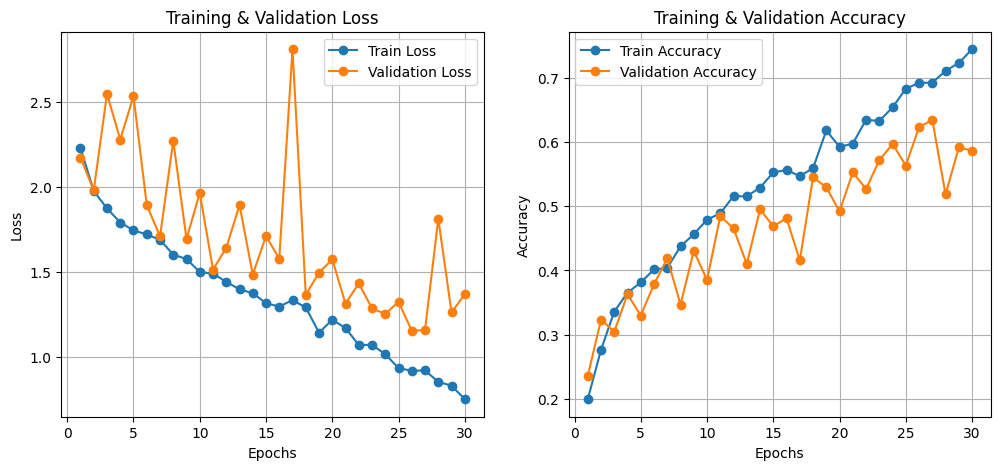

In [14]:
# 학습 설정
num_epochs = 30
patience = 5
best_loss = float("inf")
counter = 0

history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
checkpoint_path = "checkpoint.pth"

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # 검증 과정
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Early Stopping
    if counter >= patience:
        print("⛔ Early stopping triggered! Training stopped.")
        break

# 학습 과정 그래프 출력
plot_training(history)